## Learn embeddings from samples of random walks:
In its simplest form, the model represents a fully connected artificial neural network (ANN) with one hidden layer, i.e. the embedding layer, an input and output layers.  The model is fitted on a corpus of words and their associated context generated by sampling random walks from the brain graph (node2vec: Grover & Leskovec, 2016; Deepwalk: Perozzi, Al-Rfou, & Skiena, 2014). It’s goal is to predict the  target word given its context. The model's learned parameters, W and W', define the transformation between the input, embedding and output layers. In this notebook, we will go over the basics of this mechanism.

<img src="https://raw.githubusercontent.com/GidLev/cepy/master/examples/images/ce_workflow_width.png" alt="The CE workflow"/>


We will start we by derive each step in the model and then examine its output before and after the model fitting. 

First, lets import some relevant packages:

In [5]:
%%capture
!pip install cepy
!pip install -U scikit-learn
!pip install seaborn
%matplotlib inline
import cepy as ce
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

Download and read the structural connectivity data:

In [6]:
%%capture

# Structural connectivity matrix
!wget -O sub1_sc_matrix.npz 'https://github.com/GidLev/cepy/blob/master/examples/data/sub1_sc_matrix.npz?raw=true';
sc_mat = np.load('sub1_sc_matrix.npz')['x']

# Funcional connectivity matrix
!wget -O sub1_fc_matrix.npz 'https://github.com/GidLev/cepy/blob/master/examples/data/sub1_fc_matrix.npz?raw=true';
fc_mat = np.load('sub1_fc_matrix.npz')['x']

Read and store the nodes labels:


In [7]:
%%capture
# download
!wget -O schaefer200_yeo17_nodeName.csv 'https://github.com/GidLev/cepy/blob/master/examples/data/schaefer200_yeo17_nodeName.csv?raw=true';

# read and store in an array
nodes_labels = pd.read_csv('schaefer200_yeo17_nodeName.csv',header=None)[0].values # read nodes labels
nodes_labels = np.array([node[11:] for node in nodes_labels]) # array of nodes labels
nodes_hemi_color = np.array(['tab:blue' if node[:2] == 'RH' else 'tab:orange' for node in nodes_labels]) # assign colors to hemispheres

Now we initiate and fit a CE object and extract the sampled random walks. Notice that in the paper we sample multiple walks (permutations = 100), repeat the training process for each of them and average the resulting nodes (after alignment). Here we perform this process only once to save time:

In [8]:
# setting the hyper parameters
window_size = 3
dimensions = 30

# initiate the CE object
ce_subject1 = ce.CE(dimensions = dimensions, walk_length = 20, num_walks = 800, p = 0.1, 
         q = 1.6, window = 3, permutations = 1, verbosity = 2 , save_walks = True, seed = 1)
ce_subject1.fit(sc_mat) # fit (sample random walks and fit the node2vec model - this should take ~ 3 minutes)

# extract a sample of random walks
random_walk = [[int(j) for j in i] for i in ce_subject1.walks] # string nodes to int
random_walk = np.array(random_walk) # convert the random walks from a list to a NumPy array

Generating walks (CPU: 1):   0%|          | 2/800 [00:00<01:16, 10.48it/s]

Generating walks (CPU: 1): 100%|██████████| 800/800 [02:35<00:00,  5.15it/s]


Start training  1  word2vec models on  1 threads.
Done training the word2vec model  0 in 5.7184 seconds.


Now we extract an example window of *target* and *context nodes*:

In [24]:
target_index = random_walk[0,window_size]
context_indices = np.concatenate((random_walk[0,:window_size], 
                          random_walk[0,window_size+1:2*window_size+1]))
print('target:', nodes_labels[target_index], 'context:', nodes_labels[context_indices])

target: LH_VisCent_ExStr_1 context: ['LH_DefaultB_Temp_3' 'LH_Limbic_TempPole_4' 'LH_DefaultB_Temp_3'
 'LH_VisCent_ExStr_3' 'LH_VisCent_ExStr_1' 'LH_VisCent_ExStr_3']


Transfer the *target* and *context* to one-hot encoding, meaning that node *i* is encoded as a vector with zero in all its entries except the *i*<sup>th</sup> position that is equal to one:

In [25]:
def to_one_hot(nodes_indices, num_nodes):
    """Transfer a vectors of nodes indices to array of one-hot encoding"""
    one_hot = np.zeros((np.size(nodes_indices), num_nodes))
    for i, node_index in enumerate(nodes_indices):
      one_hot[i, node_index] = 1
    return one_hot

num_nodes = sc_mat.shape[0]
target = to_one_hot([target_index], num_nodes)
context = to_one_hot(context_indices, num_nodes)
print('target:', target)

target: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


Now let's test the model's output for randomly initiate parameters. The model includes two parameters: *k* × *k'* matrix *W* between the input and the embedding layer, and a *k'* × *k* matrix *W’* between the embedding layer and the output layer (*k* = number of nodes, *k'* = number of dimensions in the embedded vectors):

In [28]:
W = np.random.rand(num_nodes, dimensions)
W_apos =  np.random.rand(dimensions, num_nodes)
print('W shape:', W.shape, 'W_apos shape:', W_apos.shape)

W shape: (200, 30) W_apos shape: (30, 200)


For the continuous bag of words (CBOW) model we calculate the embedding of the context given the weights matrix *w* in the following way:

$$ v^{embedd}=\frac{1}{2\times s}\sum_{t=1}^{2\times s}\left(W^\intercal\cdot c_t\right) $$

Where: s = window size, and c<sub>t</sub> = the context node t.

In [29]:
v_embedd = np.dot(W.T, np.mean(context, axis = 0)) # Notice we taken W.T out of the sum

Similarly, the output vector given the weights matrix w':

$$ v^{output}=W^{\prime\intercal}\cdot v^{embedd} $$

In [30]:
v_output = np.dot(W_apos.T, v_embedd)

To find the predicted target node given our (randomly initiate) parameters, we apply a softmax, which turns the output vectors to probabilities:

$$ softmax\left(v^{output}\right)_i=\frac{\exp{\left(v_i^{output}\right)}}{\sum_{j=0}^{k}\exp{\left(v_j^{output}\right)}} $$

In [31]:
def softmax(x):
    """Compute softmax values for a given input vector"""
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)

prob_vector = softmax(v_output)

Now let's test the predictions:

The real target: LH_VisCent_ExStr_1
The context: ['LH_DefaultB_Temp_3' 'LH_Limbic_TempPole_4' 'LH_DefaultB_Temp_3'
 'LH_VisCent_ExStr_3' 'LH_VisCent_ExStr_1' 'LH_VisCent_ExStr_3']
The real target node was ranked 77 by the model.


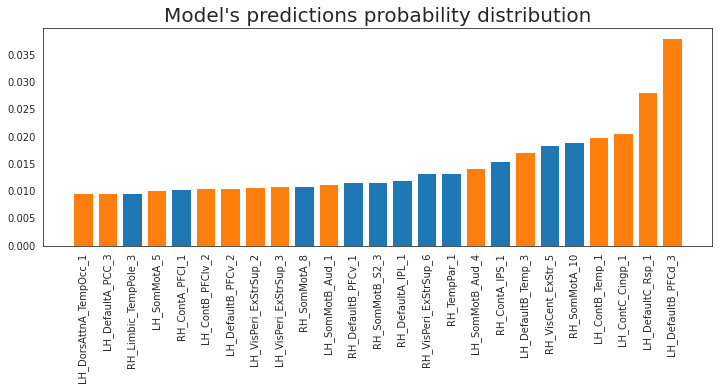

In [32]:
print('The real target:', nodes_labels[target_index])
print('The context:', nodes_labels[context_indices])
print('The real target node was ranked', np.where(np.argsort(-1*prob_vector + 1) == target_index)[0][0], 'by the model.')

# plot the [n_nodes] most probable nodes
n_nodes = 25 # number of highest probability nodes to present
fig=plt.figure(figsize=(12,4))
plt.bar(np.arange(n_nodes),prob_vector[np.argsort(prob_vector)][-1*n_nodes:], color = nodes_hemi_color[np.argsort(prob_vector)[-1*n_nodes:]])
plt.xticks(np.arange(n_nodes),nodes_labels[np.argsort(prob_vector)[-1*n_nodes:]], rotation=90)
plt.title("Model's predictions probability distribution", size=20);

In parctice the model is evaluated and optimized with the logarithmic loss, i.e. by taking the negative log of the softmax for the * entry. * denotes the index of the target node:

$$ loss=-\log{\left(\frac{\exp{\left(v_\ast^{output}\right)}}{\sum_{j=0}^{k}\exp{\left(v_j^{output}\right)}}\right)} $$

In [33]:
loss = -1 * np.log(prob_vector[target_index])
print('Loss:', loss)

Loss: 5.434601057899581


These are the results of the model before it was fit. Now let's repeat this in a fitted model. For each training sample, we update the model’s parameters W and W’, by taking the derivative of the loss with respect to each matrix. The parameters are iteratively updated after each observation using stochastic gradient descent (SGD). We won't go over SGD here, but you can find alternative tutorials, such as:

https://nbviewer.jupyter.org/github/dtnewman/gradient_descent/blob/master/stochastic_gradient_descent.ipynb

Here will use the model trained with the cepy package:


In [34]:
# Get W and W' from the model
W = ce_subject1.weights.get_w_permut(norm = False)
W_apos = ce_subject1.weights.get_w_apos_permut(norm = False)
print('W shape:', W.shape, 'W_apos shape:', W_apos.shape)

W shape: (200, 30) W_apos shape: (30, 200)


And repeat the same steps with the fitted parameters:

In [35]:
v_embedd = np.dot(W.T, np.mean(context, axis = 0)) # the embedding layer
v_output = np.dot(W_apos.T, v_embedd) # the output layer
prob_vector = softmax(v_output) # apply the Softmax

And test again:

The real target: LH_VisCent_ExStr_1
The context: ['LH_DefaultB_Temp_3' 'LH_Limbic_TempPole_4' 'LH_DefaultB_Temp_3'
 'LH_VisCent_ExStr_3' 'LH_VisCent_ExStr_1' 'LH_VisCent_ExStr_3']
The real target node was ranked 4 by the model.
Loss: 4.7140841439953745


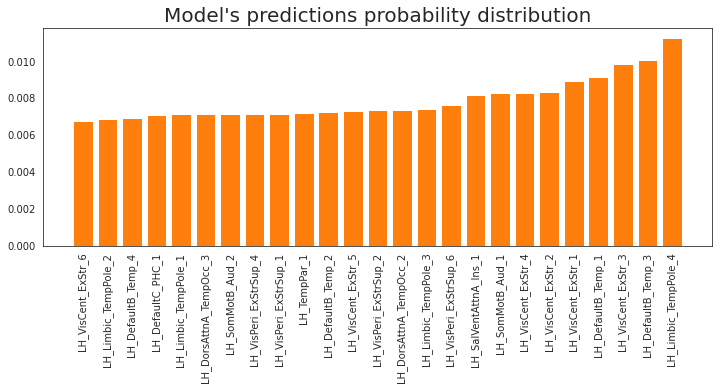

In [36]:
print('The real target:', nodes_labels[target_index])
print('The context:', nodes_labels[context_indices])
print('The real target node was ranked', np.where(np.argsort(-1*prob_vector + 1) == target_index)[0][0], 'by the model.')

# plot the [n_nodes] most probable nodes
n_nodes = 25 # number of highest probability nodes to presentfig=plt.figure(figsize=(12,4))
fig=plt.figure(figsize=(12,4))
plt.bar(np.arange(n_nodes),prob_vector[np.argsort(prob_vector)][-1*n_nodes:], color = nodes_hemi_color[np.argsort(prob_vector)[-1*n_nodes:]])
plt.xticks(np.arange(n_nodes),nodes_labels[np.argsort(prob_vector)[-1*n_nodes:]], rotation=90)
plt.title("Model's predictions probability distribution", size=20)
loss = -1 * np.log(prob_vector[target_index])
print('Loss:', loss)

**A random walk a stocastic process hence we cannot expect a perfect accuracy.** Nevertheless, we expect that nodes that were assigned with a higher probabilty would be ones that are more likely to appear in a random walk with the same context.

Of course we are intersted in the embeddings them themselves. One of the basic findings we report, is that the measured angle among these vectors significantly correlate with functional connectivity (FC), even more than the raw SC. We will now try to repreduce this, first by calculting all pairwise cosine-similarity among nodes and present them in matrix form (i.e. CE the cosine-similarity matrix):

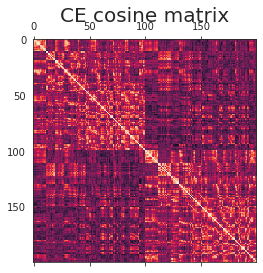

In [37]:
ce_cosine_mat = ce_subject1.similarity(method='cosine_similarity')
plt.matshow(ce_cosine_mat)
plt.title("CE cosine matrix", size=20);

Now let's load and plot the FC matrix:

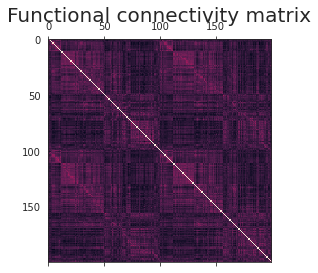

In [38]:
plt.matshow(fc_mat)
plt.title("Functional connectivity matrix", size=20);

We can now test the similarity of the SC versus the CE cosine-similarities to the FC. Since the SC matrix is highly spares we will test only direct edges (edges that are > 0 in the SC matrix):

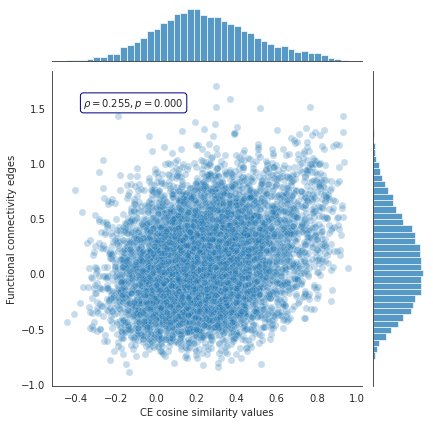

In [39]:
direct_edges_bool = np.logical_and(sc_mat > 0, np.tri(num_nodes, k=-1)) # boolean array pointing the direct nodes and the lower triangle

# arange all edge values in a dataframe for easy plotting
data = {'SC': sc_mat[direct_edges_bool], 'CE': ce_cosine_mat[direct_edges_bool] ,
        'FC': fc_mat[direct_edges_bool]}
df_edges = pd.DataFrame(data)

sns.set_style("white")
g = sns.jointplot(data=df_edges, x="CE", y="FC", kind = 'scatter', 
                  joint_kws = {'alpha': 0.25, 's': 50}) #
g.set_axis_labels('CE cosine similarity values', 'Functional connectivity edges')
# add anotation of the SC-FC Spearman correlation
r, p = stats.spearmanr(df_edges['CE'], df_edges['FC'])
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                xy=(0.1, 0.9), xycoords='axes fraction',
                ha='left', va='center',
                bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'navy'});

This should be higher than the original SC-FC correlation:

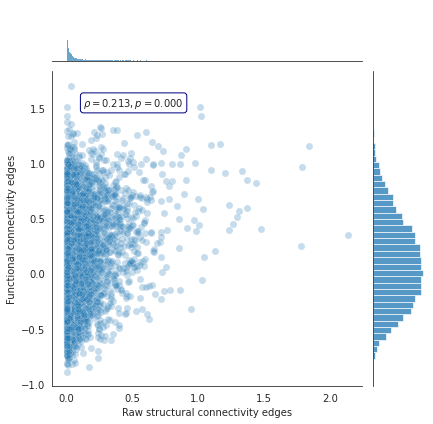

In [40]:
g = sns.jointplot(data=df_edges, x="SC", y="FC", kind = 'scatter', 
                  joint_kws = {'alpha': 0.25, 's': 50})
g.set_axis_labels('Raw structural connectivity edges', 'Functional connectivity edges')
# add anotation of the SC-FC Spearman correlation
r, p = stats.spearmanr(df_edges['SC'], df_edges['FC'])
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                xy=(0.1, 0.9), xycoords='axes fraction',
                ha='left', va='center',
                bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'navy'});

For a more in-depth review of the model and training procedure including implementational details that are beyond the scope of the current work such as negative sampling, see Rong (2014).

### Reference


* Grover, A., & Leskovec, J. (2016). node2vec: Scalable Feature Learning for Networks. KDD : Proceedings. International Conference on Knowledge Discovery & Data Mining, 2016, 855–864. https://doi.org/10.1145/2939672.2939754

* Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online learning of social representations. In Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 701–710). New York, New York, USA: Association for Computing Machinery. https://doi.org/10.1145/2623330.2623732

* Rong, X. (2014). word2vec Parameter Learning Explained. ArXiv. http://arxiv.org/abs/1411.2738
